# Preparation
After run ```python setup.py build_ext -if``` the module is installed **inplace** (the \_simtod*.so file is exactly the module). So first add the path to so file in PYTHONPATH environment.

In [1]:
import sys
sys.path.append('../')
import _simtod

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import camb

import warnings
warnings.filterwarnings('ignore')
np.random.seed(123)

# Generate a CMB T map

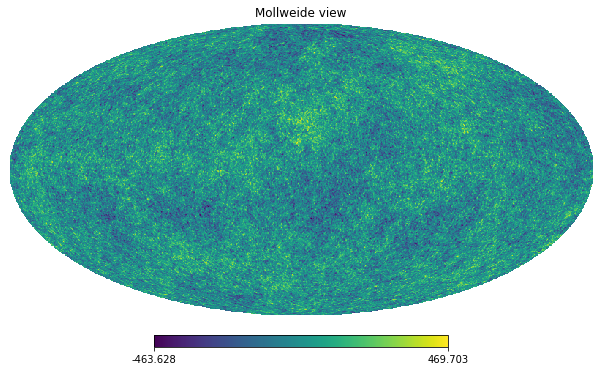

In [3]:
nside = 1024
npix  = hp.nside2npix(nside)

pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
pars.set_for_lmax(4000, lens_potential_accuracy=0)
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True)
totCL=powers['total']

cltt = totCL[:,0]
maps = hp.synfast(cltt, nside)
hp.mollview(maps)

# TOD Simulation
## 1. Pixel domain convolution (more accurate)

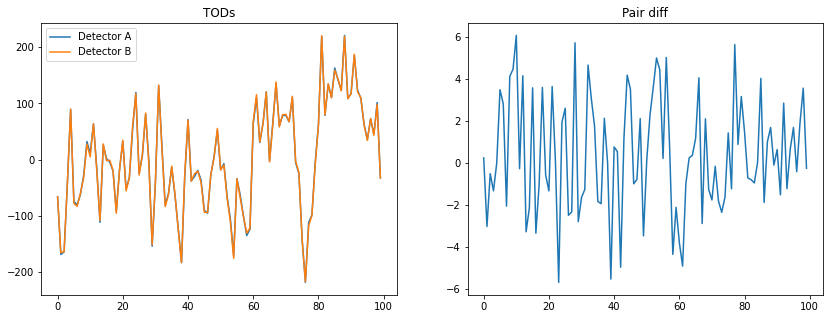

In [4]:
# Set beam mismatch parameters
beam_para = (0, 0.7, 0.3, 19, 0.5, 0.002, 0.001)

# Scan strategy
theta = np.linspace(np.pi/4, np.pi/2, 100)
phi   = np.linspace(np.pi/4, np.pi/2, 100)
psi   = np.linspace(0, np.pi * 2, 100)

# TOD simulation
tods_acc = _simtod.simtod(beam_para, maps, theta, phi, psi)

# Plot
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(tods_acc[0], label='Detector A')
plt.plot(tods_acc[1], label='Detector B')
plt.legend()
plt.title('TODs')
plt.subplot(122)
pair_diff_acc = tods_acc[0] - tods_acc[1]
plt.plot(pair_diff_acc)
plt.title('Pair diff');

## 2.  Template TOD (for deprojection, more approximate)
Calculate derivatives $\partial_{\theta}, \partial_{\phi}, \partial_{\theta\theta}, \partial_{\theta\phi}, \partial_{\phi\phi}$

In [5]:
#der1
alms = hp.map2alm(maps)
_, dt_map, dp_map = hp.alm2map_der1(alms, nside)

#der2
alms = hp.map2alm(dt_map)
_, dtt_map, dtp_map = hp.alm2map_der1(alms, nside)

alms = hp.map2alm(dp_map)
_, _, dpp_map = hp.alm2map_der1(alms, nside)

deriv_maps = np.zeros((6, npix))
deriv_maps[0] = maps
deriv_maps[1] = dt_map
deriv_maps[2] = dp_map
deriv_maps[3] = dtt_map
deriv_maps[4] = dpp_map
deriv_maps[5] = dtp_map

for i in range(6):
    deriv_maps[i] = hp.smoothing(deriv_maps[i], np.deg2rad(19/60))

In [6]:
tods_app = _simtod.templatetod(beam_para, deriv_maps, theta, phi, psi)

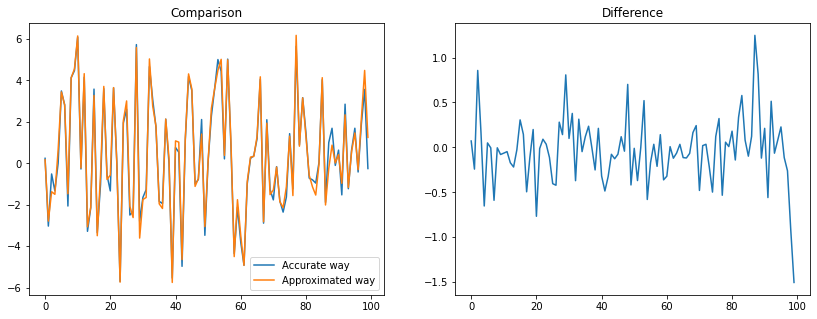

In [7]:
plt.figure(figsize=(14,5))

plt.subplot(121)
pair_diff_app = tods_app[0] - tods_app[1]
plt.plot(pair_diff_acc, label='Accurate way')
plt.plot(pair_diff_app, label='Approximated way')
plt.legend()
plt.title('Comparison')

plt.subplot(122)
plt.plot(pair_diff_acc - pair_diff_app)
plt.title('Difference');

## 3. Mapmaking

In [8]:
n_scan = 256

_theta, _phi = hp.pix2ang(nside, np.arange(npix))
theta_list = np.split(np.tile(_theta, 3), n_scan)
phi_list = np.split(np.tile(_phi, 3), n_scan)
psi_list = np.split(np.random.uniform(0, np.pi/2, npix*3), n_scan)

In [9]:
tod_list = []
for i in range(n_scan):
    print("%05.2f%%"%((i+1)/n_scan * 100), end='\r')
    tod_list.append(_simtod.simtod(beam_para, maps, theta_list[i], phi_list[i], psi_list[i]))

In [10]:
nside_mmk = 512
mmk = _simtod.MapMaking(nside_mmk)
for i in range(n_scan):
    print("%05.2f%%"%((i+1)/n_scan * 100), end='\r')
    mmk.add_Scan(tod_list[i], theta_list[i], phi_list[i], psi_list[i])

In [11]:
t, q, u = mmk.get_Map()
hitmap  = mmk.get_Hitmap()

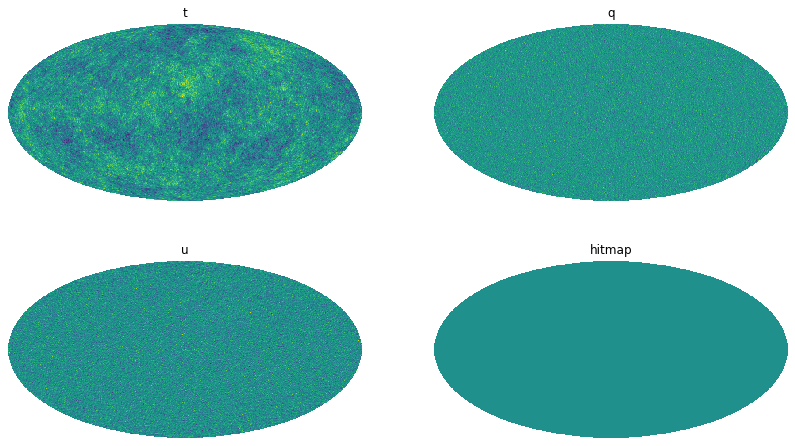

In [12]:
plt.figure(figsize = (14, 8))
plt.subplot(221)
hp.mollview(t, hold=True, title='t', cbar=False)
plt.subplot(222)
hp.mollview(q, hold=True, title='q', cbar=False)
plt.subplot(223)
hp.mollview(u, hold=True, title='u', cbar=False)
plt.subplot(224)
hp.mollview(hitmap, hold=True, title='hitmap', cbar=False)